In [7]:
import importlib
import __init__  # Import the module

# Reload the entire module to apply any changes made in __init__.py
importlib.reload(__init__)

# Import the functions from your __init__.py file
from __init__ import (
    read_master,      # Loads the master data file (HDF or CSV)
    filter_symbol,    # Filters individual stock data based on a query or search term
    read_from_key,    # Reads stock market data associated with a specific key (from HDF or CSV)
    read_data         # Retrieves stock data after filtering symbols
)

In [8]:
import pandas as pd
import numpy as np

# --- Load and filter raw data ---
nifty_data = read_data(query="NIFTY 50", use_hdf=True)

# Remove timezone info and filter date range
nifty_data.index = nifty_data.index.tz_localize(None)
data_start_date = pd.Timestamp("2019-01-02")
data_end_date = pd.Timestamp("2020-03-03")
filtered_stock_data = nifty_data.loc[data_start_date:data_end_date]["close"]

# --- Compute raw log returns ---
returns = np.log(filtered_stock_data / filtered_stock_data.shift(1)).dropna()

# Exclude specific hours (17, 18, 19)
excluded_hours = [17, 18, 19]
returns = returns[~returns.index.hour.isin(excluded_hours)]
filtered_stock_data = filtered_stock_data[~filtered_stock_data.index.hour.isin(excluded_hours)]

# --- Resampling and aggregating returns ---
# Hourly returns: sum within each hour
hourly_returns = returns.groupby(returns.index.floor('H')).sum()
hourly_returns = pd.Series(hourly_returns, name='Hourly Log Return (All Hours)')

# Daily returns: sum within each day
daily_returns = returns.groupby(returns.index.floor('D')).sum()
daily_returns = pd.Series(daily_returns, name='Daily Log Return (All Hours)')

# --- Resampling prices ---
hourly_prices = filtered_stock_data.resample('H').last().dropna()
daily_prices = filtered_stock_data.resample('D').last().dropna()



In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title="ADF Test"):
    print(f"\n{title}")
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
    for key, val in result[4].items():
        print(f'Critical Value ({key}): {val}')
    if result[1] < 0.05:
        print("=> The series is stationary (reject H₀)")
    else:
        print("=> The series is non-stationary (fail to reject H₀)")

# Perform ADF test on daily and hourly returns

adf_test(daily_returns, title="ADF Test on Daily Returns")

adf_test(hourly_returns, title="ADF Test on Hourly Returns")



ADF Test on Daily Returns
ADF Statistic: -15.625679261556709
p-value: 1.7100371559085581e-28
# Lags Used: 0
# Observations: 286
Critical Value (1%): -3.4534232986669546
Critical Value (5%): -2.8716994185534745
Critical Value (10%): -2.5721833625116144
=> The series is stationary (reject H₀)

ADF Test on Hourly Returns
ADF Statistic: -23.239286697048858
p-value: 0.0
# Lags Used: 2
# Observations: 2006
Critical Value (1%): -3.4336140516629836
Critical Value (5%): -2.8629818846551376
Critical Value (10%): -2.5675375973574788
=> The series is stationary (reject H₀)


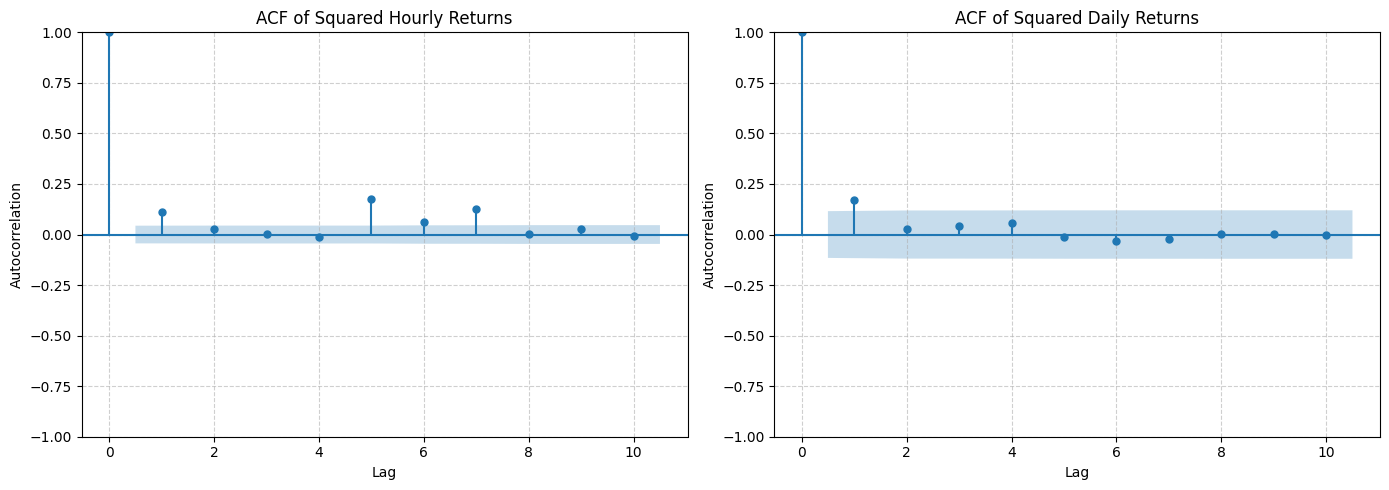

In [10]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF for squared hourly returns
plot_acf(hourly_returns**2, lags=10, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF of Squared Hourly Returns')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot ACF for squared daily returns
plot_acf(daily_returns**2, lags=10, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of Squared Daily Returns')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Rolling GARCH-in-Mean Quantile Forecasting and Evaluation

This module implements a **rolling-window GARCH-in-Mean forecasting pipeline** with quantile estimation and evaluation metrics.

#### `rolling_garch_forecast(...)`

A rolling GARCH(1,1) model is fit on historical return windows to forecast:

- The **conditional mean** of returns, estimated via GARCH-in-mean linear regression.
- The **conditional volatility**, forecasted from the GARCH model.
- **Quantile forecasts** of returns and prices based on the normal distribution assumption.

**Parameters**:
- `returns`: Return series (e.g., log-returns).
- `prices`: Price series for converting return quantiles into price quantiles.
- `window`: Length of rolling window (e.g., `'30D'`, `60`, `{'days': 30}`).
- `quantiles`: List of desired quantiles (e.g., `[0.05, 0.95]`).
- `scaling_factor`: Multiplies returns for numerical stability during fitting.
- `min_periods`: Minimum observations required to fit the GARCH model.

Each forecasted timestamp contains:
- Mean and volatility forecasts
- Quantiles for returns and prices
- The actual price at the forecast time

####  `evaluate_forecast_performance(...)`

Evaluates the quality of the quantile forecasts using:
- **Coverage rate**: % of times the realized value falls within the forecast interval.
- **Winkler score**: Penalizes both wide intervals and those that miss the realized value.
- **Pinball loss**: Standard loss for quantile regression.

**Evaluation Metrics Are Reported For**:
- **Return intervals**: e.g., whether the realized return falls within the `[5%, 95%]` return quantile interval.
- **Price intervals**: e.g., whether the actual price falls within the `[5%, 95%]` predicted price interval.

**Output**:
- A printed coverage summary for each interval.
- A dictionary of results with expected vs actual coverage, Winkler scores, and number of valid forecasts.

---

 **Note**: The model assumes normality when computing quantiles. In practice, consider alternative distributions (e.g., Student-t) if your data is heavy-tailed.


In [11]:

from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def get_window_size(window_spec, data_freq):
    """
    Convert window specification to number of observations
    
    Parameters:
    -----------
    window_spec : int, str, or dict
        Window specification (e.g., 60, '30D', {'days': 30})
    data_freq : str
        Data frequency ('D', 'H', 'W')
    """
    if isinstance(window_spec, int):
        return window_spec
    
    if isinstance(window_spec, str):
        window_td = pd.Timedelta(window_spec)
    elif isinstance(window_spec, dict):
        window_td = pd.Timedelta(**window_spec)
    else:
        raise ValueError("window_spec must be int, str, or dict")
    
    # Convert to observations based on frequency
    freq_map = {'D': pd.Timedelta(days=1), 'H': pd.Timedelta(hours=1), 'W': pd.Timedelta(weeks=1)}
    base_freq = freq_map.get(data_freq, pd.Timedelta(days=1))
    
    return int(window_td / base_freq)

def rolling_garch_forecast(returns, prices, window='30D', quantiles=[0.05, 0.95], 
                          scaling_factor=100, min_periods=30):
    """
    Rolling GARCH-in-Mean forecasting with multiple quantiles
    
    Parameters:
    -----------
    returns : pd.Series
        Time series of returns
    prices : pd.Series  
        Time series of prices
    window : int, str, or dict
        Window specification
    quantiles : list
        List of quantiles to compute (e.g., [0.05, 0.25, 0.75, 0.95])
    scaling_factor : float
        Scaling factor for numerical stability
    min_periods : int
        Minimum number of observations required
    """
    
    # Detect data frequency
    time_diffs = returns.index.to_series().diff().dropna()
    median_diff = time_diffs.median()
    
    if median_diff <= pd.Timedelta(hours=2):
        data_freq = 'H'
    elif median_diff <= pd.Timedelta(days=1.5):
        data_freq = 'D'
    else:
        data_freq = 'W'
    
    # Convert window to observations
    window_size = get_window_size(window, data_freq)
    
    print(f"Data frequency: {data_freq}")
    print(f"Window size: {window_size} observations")
    print(f"Minimum periods: {min_periods}")
    
    n = len(returns)
    results = []
    
    # Start from minimum required index
    start_idx = max(min_periods, window_size)
    
    for i in range(start_idx, n):
        # Get window data
        window_start = max(0, i - window_size)
        window_returns = returns.iloc[window_start:i] * scaling_factor
        
        if len(window_returns) < min_periods:
            continue
            
        current_price = prices.iloc[i - 1]
        
        try:
            # Fit GARCH(1,1)
            cm = ConstantMean(window_returns)
            cm.volatility = GARCH(1, 0, 1)
            cm.distribution = Normal()
            res = cm.fit(disp='off')
            
            # Get conditional volatility
            sigma = res.conditional_volatility
            
            # GARCH-in-mean regression
            lr = LinearRegression()
            lr.fit(sigma.values.reshape(-1, 1), window_returns.values)
            lambda_coef = lr.coef_[0]
            mu = lr.intercept_
            
            # Forecast volatility
            forecast = res.forecast(horizon=1)
            sigma_forecast = np.sqrt(forecast.variance.iloc[-1, 0])
            mean_forecast = mu + lambda_coef * sigma_forecast
            
            # Scale back
            mean_forecast /= scaling_factor
            sigma_forecast /= scaling_factor
            
            # Calculate multiple quantiles
            result_row = {
                'mean_return_forecast': mean_forecast,
                'volatility_forecast': sigma_forecast,
                'actual_price': current_price,
                'window_size_used': len(window_returns)
            }
            
            # Add quantile forecasts
            for q in quantiles:
                z_score = stats.norm.ppf(q)
                return_quantile = mean_forecast + z_score * sigma_forecast
                price_quantile = current_price * np.exp(return_quantile)
                
                result_row[f'return_q{q:.3f}'] = return_quantile
                result_row[f'price_q{q:.3f}'] = price_quantile
            
            result_row['timestamp'] = returns.index[i]
            results.append(result_row)
            
        except Exception as e:
            print(f"Warning at step {i}: {e}")
            continue
    
    print(f"Generated {len(results)} forecasts")
    
    if len(results) == 0:
        raise ValueError("No successful forecasts generated")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('timestamp', inplace=True)
    
    return results_df

def pinball_loss(y_true, y_pred, quantile):
    return np.maximum((quantile - 1) * (y_true - y_pred), quantile * (y_true - y_pred))

def winkler_score(y_true, q_low, q_high, alpha):
    """
    Winkler score for a prediction interval [q_low, q_high] with coverage 1-alpha
    """
    interval_width = q_high - q_low
    score = np.where(
        y_true < q_low,
        interval_width + 2 / alpha * (q_low - y_true),
        np.where(
            y_true > q_high,
            interval_width + 2 / alpha * (y_true - q_high),
            interval_width
        )
    )
    return score

def evaluate_forecast_performance(results_df, returns, prices, quantiles=[0.05, 0.95]):
    """
    Evaluate forecast performance for multiple symmetric quantile intervals.
    Adds Pinball Loss and Winkler Score.
    """
    aligned_returns = []
    aligned_prices = []

    for idx in results_df.index:
        if idx in returns.index:
            aligned_returns.append(returns.loc[idx])
            aligned_prices.append(prices.loc[idx])
        else:
            try:
                nearest_return_idx = returns.index[returns.index.get_indexer([idx], method='nearest')[0]]
                nearest_price_idx = prices.index[prices.index.get_indexer([idx], method='nearest')[0]]

                if abs((nearest_return_idx - idx).total_seconds()) < 24 * 3600:
                    aligned_returns.append(returns.loc[nearest_return_idx])
                    aligned_prices.append(prices.loc[nearest_price_idx])
                else:
                    aligned_returns.append(np.nan)
                    aligned_prices.append(np.nan)
            except:
                aligned_returns.append(np.nan)
                aligned_prices.append(np.nan)

    results_df['realized_return'] = aligned_returns
    results_df['realized_price'] = aligned_prices

    coverage_results = {}

    # Find symmetric quantile pairs
    sorted_q = sorted(quantiles)
    quantile_pairs = [(q, 1 - q) for q in sorted_q if q < 0.5 and (1 - q) in sorted_q]

    print("\nCoverage Analysis:")
    for q_low, q_high in quantile_pairs:
        alpha = q_low + (1 - q_high)
        confidence_level = 1 - alpha

        key = f'{confidence_level:.0%}_band'

        result = {'expected_coverage': confidence_level}

        for target, label in [('return', 'realized_return'), ('price', 'realized_price')]:
            ql_col = f'{target}_q{q_low:.3f}'
            qh_col = f'{target}_q{q_high:.3f}'

            valid = results_df.dropna(subset=[label, ql_col, qh_col])
            if len(valid) == 0:
                result[f'{target}_coverage'] = np.nan
                result[f'{target}_winkler'] = np.nan
                continue

            inside = (valid[label] >= valid[ql_col]) & (valid[label] <= valid[qh_col])
            coverage = inside.mean()

            winkler = winkler_score(valid[label].values, valid[ql_col].values, valid[qh_col].values, alpha).mean()

            result[f'{target}_coverage'] = coverage
            result[f'{target}_winkler'] = winkler
            result['valid_forecasts'] = len(valid)

        coverage_results[key] = result

        print(f"{key} ({q_low:.3f}-{q_high:.3f}):")
        print(f"  Return coverage:  {result['return_coverage']:.2%}  | Winkler: {result['return_winkler']:.4f}")
        print(f"  Price coverage:   {result['price_coverage']:.2%}   | Winkler: {result['price_winkler']:.4f}")
        print(f"  Valid forecasts:  {result['valid_forecasts']}")


    return coverage_results

def plot_forecast_results(returns, prices, results_df, quantiles=[0.05, 0.95], 
                          plot_type='both', figsize=(16, 12), max_points=1000,
                          realized_vol_window=20, hf_returns=None):
    """
    Plot forecast results with multiple quantile bands and realized volatility.
    
    Parameters:
    - returns: pd.Series of daily returns
    - prices: pd.Series of daily prices
    - results_df: DataFrame with forecast results (indexed by date)
    - quantiles: list of quantile levels (e.g. [0.05, 0.95])
    - plot_type: 'returns', 'prices', or 'both'
    - figsize: tuple defining the figure size
    - max_points: max number of points to plot
    - realized_vol_window: rolling window size for fallback realized volatility
    - hf_returns: (optional) pd.Series of high-frequency returns
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np
    import pandas as pd

    # Subsample if necessary
    if len(results_df) > max_points:
        step = len(results_df) // max_points
        plot_results = results_df.iloc[::step].copy()
    else:
        plot_results = results_df.copy()

    # Align actual values
    actual_returns, actual_prices = [], []
    for date in plot_results.index:
        actual_returns.append(returns.get(date, np.nan))
        actual_prices.append(prices.get(date, np.nan))

    plot_results['actual_return'] = actual_returns
    plot_results['actual_price'] = actual_prices
    plot_results.dropna(subset=['actual_return', 'actual_price'], inplace=True)

    if len(plot_results) == 0:
        print("No valid data points for plotting.")
        return None

    # Realized volatility computation
    if hf_returns is not None:
        # Realized vol from intraday returns
        realized_vol = hf_returns.pow(2).groupby(hf_returns.index.date).sum().apply(np.sqrt)
        realized_vol.index = pd.to_datetime(realized_vol.index)
    else:
        # Fallback: rolling std of daily returns
        realized_vol = returns.rolling(window=realized_vol_window).std()

    plot_results['realized_volatility'] = realized_vol.reindex(plot_results.index)

    # Set up subplots
    if plot_type == 'both':
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
    elif plot_type in ['returns', 'prices']:
        fig, axes = plt.subplots(1, 2, figsize=(figsize[0], figsize[1]//2))
    else:
        raise ValueError("plot_type must be 'returns', 'prices', or 'both'")

    # Quantile bands
    sorted_q = sorted(quantiles)
    quantile_pairs = [(q, 1 - q) for q in sorted_q if q < 0.5 and (1 - q) in sorted_q]
    colors = plt.cm.YlGnBu(np.linspace(0.3, 0.8, len(quantile_pairs)))

    idx = 0

    # Plot Returns
    if plot_type in ['returns', 'both']:
        ax = axes[idx]
        for i, (q_low, q_high) in enumerate(quantile_pairs):
            confidence = 1 - (q_low + (1 - q_high))
            ax.fill_between(plot_results.index, 
                            plot_results[f'return_q{q_low:.3f}'], 
                            plot_results[f'return_q{q_high:.3f}'],
                            color=colors[i], alpha=0.4,
                            label=f'{confidence:.0%} Band')
        ax.plot(plot_results.index, plot_results['mean_return_forecast'],
                color='blue', linewidth=1.5, label='Mean Forecast')
        ax.scatter(plot_results.index, plot_results['actual_return'], 
                   color='red', s=8, alpha=0.7, label='Actual')
        ax.set_title('Return Forecasts with Multiple Quantile Bands')
        ax.set_ylabel('Returns')
        ax.legend()
        ax.grid(alpha=0.3)
        idx += 1

        # Volatility forecast vs realized
        if plot_type == 'both':
            ax = axes[idx]
            ax.plot(plot_results.index, plot_results['volatility_forecast'],
                    color='orange', linewidth=1.5, label='Volatility Forecast')
            ax.plot(plot_results.index, plot_results['realized_volatility'],
                    color='green', linestyle='--', linewidth=1.5, 
                    label=('Realized Volatility (HF)' if hf_returns is not None 
                           else f'Realized Volatility ({realized_vol_window}d)'))
            ax.set_title('Volatility Forecast vs Realized')
            ax.set_ylabel('Volatility')
            ax.legend()
            ax.grid(alpha=0.3)
            idx += 1

    # Plot Prices
    if plot_type in ['prices', 'both']:
        ax = axes[idx]
        for i, (q_low, q_high) in enumerate(quantile_pairs):
            confidence = 1 - (q_low + (1 - q_high))
            ax.fill_between(plot_results.index, 
                            plot_results[f'price_q{q_low:.3f}'], 
                            plot_results[f'price_q{q_high:.3f}'],
                            color=colors[i], alpha=0.4,
                            label=f'{confidence:.0%} Band')
        ax.plot(plot_results.index, plot_results['actual_price'],
                color='red', linewidth=1.5, label='Actual Price')
        ax.set_title('Price Forecasts with Multiple Quantile Bands')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(alpha=0.3)
        idx += 1

        # Coverage indicators
        if plot_type == 'both' and idx < len(axes):
            ax = axes[idx]
            if quantile_pairs:
                q_low, q_high = quantile_pairs[0]  # Widest band
                return_cov = (plot_results['actual_return'] >= plot_results[f'return_q{q_low:.3f}']) & \
                             (plot_results['actual_return'] <= plot_results[f'return_q{q_high:.3f}'])
                price_cov = (plot_results['actual_price'] >= plot_results[f'price_q{q_low:.3f}']) & \
                            (plot_results['actual_price'] <= plot_results[f'price_q{q_high:.3f}'])

                ax.scatter(plot_results.index, [1] * len(plot_results),
                           c=['green' if x else 'red' for x in return_cov],
                           s=15, label='Return Coverage', alpha=0.7)
                ax.scatter(plot_results.index, [0] * len(plot_results),
                           c=['blue' if x else 'red' for x in price_cov],
                           s=15, label='Price Coverage', alpha=0.7)

                ax.set_ylim(-0.5, 1.5)
                ax.set_yticks([0, 1])
                ax.set_yticklabels(['Price Coverage', 'Return Coverage'])
                ax.set_title('Coverage Indicators (Widest Band)')
                ax.legend()
                ax.grid(alpha=0.3)

    # Format x-axis for all subplots
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    return fig

def run_garch_forecast(returns, prices, window='30D', quantiles=[0.01, 0.05, 0.25, 0.75, 0.95, 0.99]):
    """
    Complete example of running GARCH forecast with multiple quantiles
    """
    print("Running GARCH-in-Mean forecast...")
    
    # Run forecast
    results = rolling_garch_forecast(returns, prices, window=window, quantiles=quantiles)

    # Evaluate performance
    performance = evaluate_forecast_performance(results, returns, prices, quantiles)
    
    # Plot results
    fig = plot_forecast_results(returns, prices, results, quantiles, plot_type='both')


    
    return results, performance, fig,

Running GARCH-in-Mean forecast...
Data frequency: D
Window size: 50 observations
Minimum periods: 30
Generated 237 forecasts

Coverage Analysis:
90%_band (0.050-0.950):
  Return coverage:  86.50%  | Winkler: 0.0440
  Price coverage:   86.50%   | Winkler: 512.9429
  Valid forecasts:  237
80%_band (0.100-0.900):
  Return coverage:  74.68%  | Winkler: 0.0351
  Price coverage:   74.68%   | Winkler: 408.7860
  Valid forecasts:  237
70%_band (0.150-0.850):
  Return coverage:  66.67%  | Winkler: 0.0299
  Price coverage:   66.67%   | Winkler: 347.2324
  Valid forecasts:  237
50%_band (0.250-0.750):
  Return coverage:  46.41%  | Winkler: 0.0234
  Price coverage:   46.41%   | Winkler: 271.4850
  Valid forecasts:  237


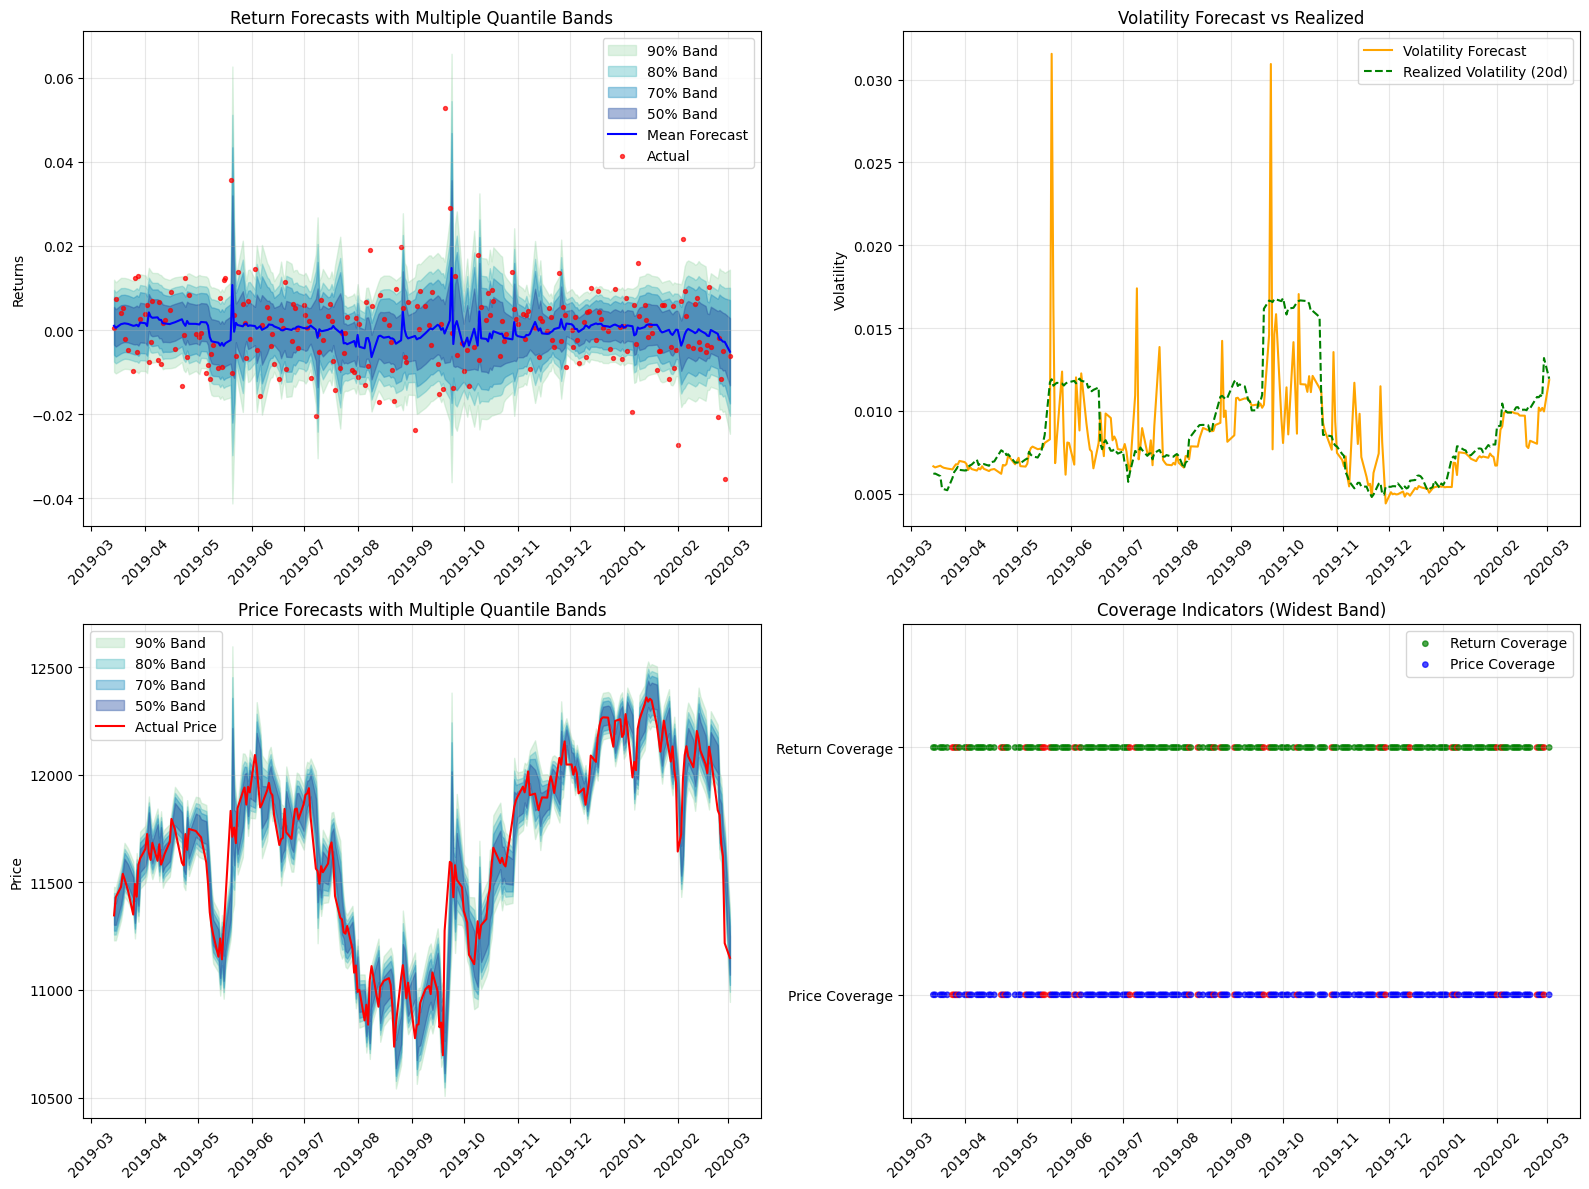

In [12]:
quantiles = [0.05,0.1,0.15,0.25,0.75,0.85,0.9, 0.95]
results, performance, fig = run_garch_forecast(
    daily_returns, daily_prices, 
    window='50D', 
    quantiles=quantiles
)


### Generic Threshold-Based Trading Strategy

This strategy goes **long** if the predicted return exceeds a positive threshold, **short** if it falls below the negative threshold, and remains **flat** otherwise.

- Positions are determined based on `log_return_pred` and the `threshold`.
- Two prediction types are supported:
  - `"close_open"`: positions are considered intraday; costs are incurred both at open and close if holding.
  - `"close_close"` (default): transaction costs are applied only on position changes.
- The strategy returns are calculated net of transaction costs.


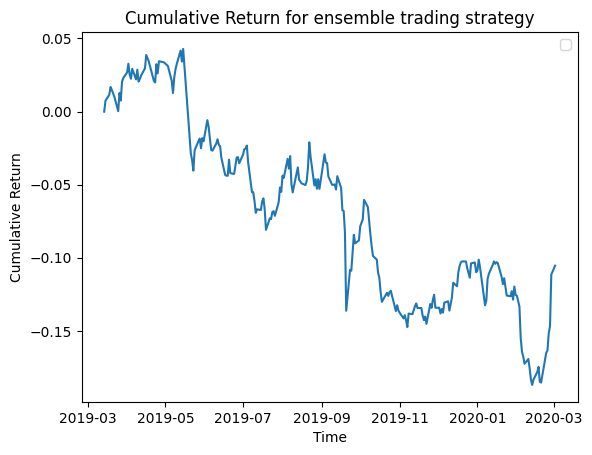

In [13]:

def trading_strategy(log_return_pred, log_return_true, type_pred="close_close", transaction_cost = 0.0005, threshold = 0.0001):

    positions = np.where(log_return_pred > threshold, 1,
                 np.where(log_return_pred < -threshold, -1, 0))


    if type_pred == "close_open":
      # Pay transaction cost considering at night I am out of the market
      prev_pos_nz = positions[:-1] != 0
      curr_pos_nz = positions[1:] != 0

      costs = np.zeros_like(positions, dtype=float)

      costs[1:] = transaction_cost * (prev_pos_nz.astype(int) + curr_pos_nz.astype(int))

      # Pay also at start
      costs[0] = transaction_cost * (positions[0] != 0).astype(int)

    else:

      pos_change = np.diff(positions, prepend=0)
      costs = np.abs(pos_change).astype(float) * transaction_cost


    strategy_return = (positions * log_return_true) - costs
    cumulative_return = np.cumsum(strategy_return)

    return pd.DataFrame({
        'Position': positions,
        'Strategy Return': strategy_return,
        'Cumulative Return': cumulative_return,
        'Costs': costs
    })

# Automatically select all columns starting with "return_q"
quantile_cols = [col for col in results.columns if col.startswith('return_q')]

# Compute the ensemble signal
ensemble_pred = results[quantile_cols].mean(axis=1)

outcome = trading_strategy(ensemble_pred, daily_returns[50:], type_pred="close_close", transaction_cost=0.0005, threshold=0.0001)
plt.plot(outcome['Cumulative Return'])
    
plt.legend(loc='best')
plt.title("Cumulative Return for ensemble trading strategy")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()


### Probability-Based Directional Strategy

This strategy infers the **probability of a positive return** from the model’s predicted quantiles by assuming 0 lies within the predicted interval \([q_{\text{low}}, q_{\text{high}}]\). The probability is approximated as:

$$
\hat{P}(r > 0) \approx \frac{q_{\text{high}} - 0}{q_{\text{high}} - q_{\text{low}}}
$$

#### Trading Logic:
- Go **long** if $$\hat{P}(r > 0) > \text{threshold} $$
- Go **short** if $$\hat{P}(r > 0) < 1 - \text{threshold}$$
- Stay flat otherwise

Transaction costs are applied when positions change. This strategy exploits asymmetric predicted intervals and is effective when quantile forecasts are reliable.


Probability positive range: 0.2522 to 0.6995


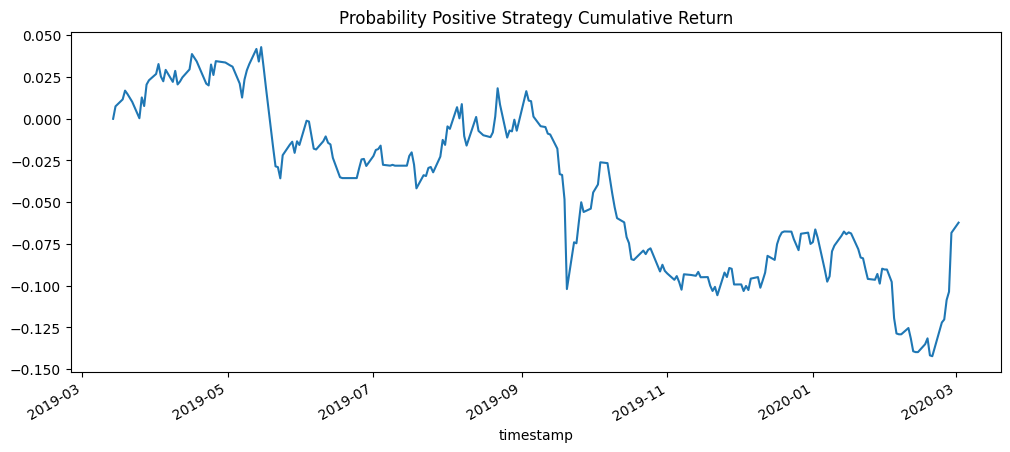

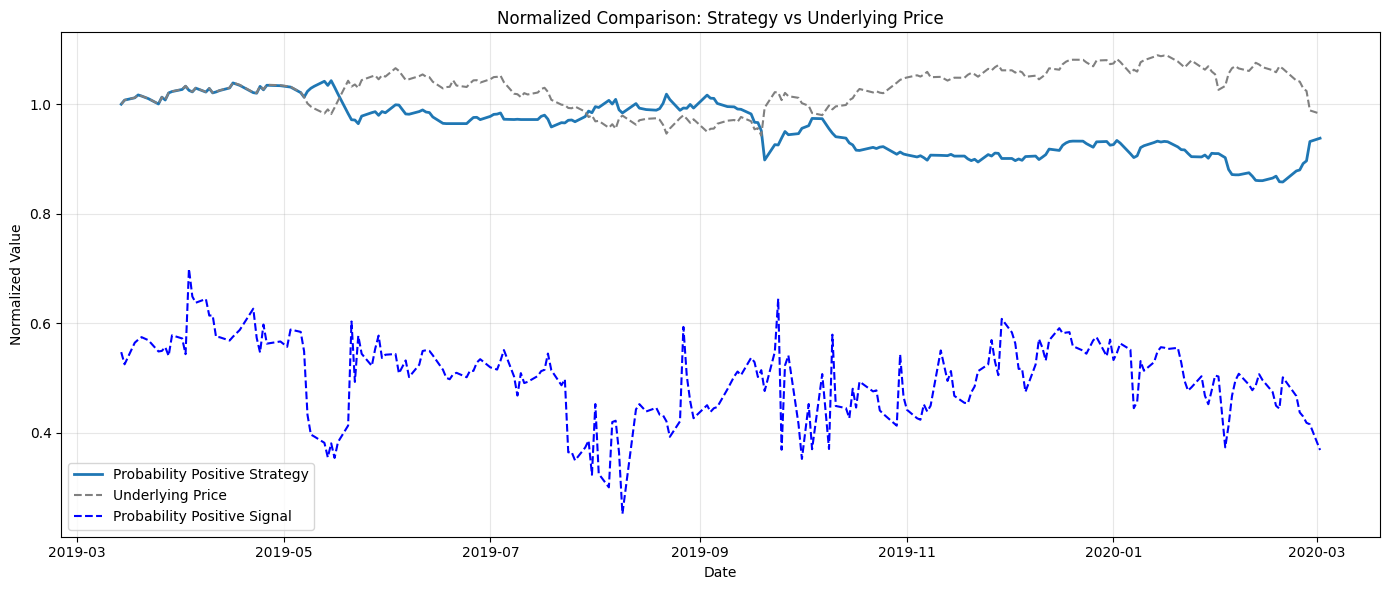

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def probability_positive_strategy(q_low, q_high, true_returns, threshold=0.51, transaction_cost=0.0005):
    """
    Trading strategy based on the approximate probability of positive return,
    assuming 0 lies between q_low and q_high quantiles.

    Parameters:
    - q_low, q_high: pd.Series of quantile forecasts (e.g. 0.01 and 0.99)
    - true_returns: pd.Series or np.array of true returns
    - threshold: float, minimum p_positive to trigger long (> threshold)
                 or short (< 1 - threshold)
    - transaction_cost: float, cost paid on position changes

    Returns:
    - pd.DataFrame with columns:
        'p_positive': probability positive signal,
        'Position': trading positions,
        'Strategy Return': returns net of transaction costs,
        'Cumulative Return': cumulative strategy returns,
        'Costs': transaction costs incurred
    """
    # Avoid division by zero
    denom = (q_high - q_low).replace(0, np.nan)

    # Compute approximate probability positive
    p_positive = (q_high - 0) / denom
    print(f"Probability positive range: {p_positive.min():.4f} to {p_positive.max():.4f}")

    # Clip to [0,1] and fill NaNs with neutral 0.5
    p_positive = p_positive.clip(0, 1).fillna(0.5)

    # Generate positions based on threshold
    positions = np.where(p_positive > threshold, 1,
                         np.where(p_positive < 1 - threshold, -1, 0))

    # Compute transaction costs on position changes
    pos_change = np.diff(positions, prepend=0)
    costs = np.abs(pos_change) * transaction_cost

    # Calculate strategy returns net of costs
    strategy_returns = positions * true_returns - costs

    # Compute cumulative returns
    cumulative_returns = strategy_returns.cumsum()

    return pd.DataFrame({
        'p_positive': p_positive,
        'Position': positions,
        'Strategy Return': strategy_returns,
        'Cumulative Return': cumulative_returns,
        'Costs': costs
    })


def compute_probability_positive_strategy(results_df, true_returns, threshold=0.51, transaction_cost=0.0005):
    q_low = results_df['return_q0.050']
    q_high = results_df['return_q0.950']
    return probability_positive_strategy(q_low, q_high, true_returns, threshold, transaction_cost)


# Run the strategy
prob_strategy_df = compute_probability_positive_strategy(
    results, daily_returns[50:], threshold=0.51, transaction_cost=0.0005
)

# Plot cumulative returns
prob_strategy_df['Cumulative Return'].plot(figsize=(12, 5), title='Probability Positive Strategy Cumulative Return')

# Normalize cumulative returns and underlying price for comparison
normalized_cum_return = 1 + (prob_strategy_df["Cumulative Return"] - prob_strategy_df["Cumulative Return"].iloc[0])
normalized_price = daily_prices.loc[prob_strategy_df.index]
normalized_price = normalized_price / normalized_price.iloc[0]

plt.figure(figsize=(14, 6))
plt.plot(normalized_cum_return, label="Probability Positive Strategy", linewidth=2)
plt.plot(normalized_price, label="Underlying Price", linestyle="--", color="gray")
plt.plot(prob_strategy_df['p_positive'], label="Probability Positive Signal", linestyle="--", color="blue")
plt.title("Normalized Comparison: Strategy vs Underlying Price")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Tail Exceedance Mean Reversion Strategy

This strategy builds a **mean-reverting signal** based on the frequency of past tail exceedances. Specifically, it counts how often the actual return has fallen **below a lower quantile** or **above an upper quantile** over a rolling window. 

- A significantly higher number of **downside breaches** suggests a potential overreaction → **long position**.
- A significantly higher number of **upside breaches** suggests overextension → **short position**.

Positions are entered when the tail imbalance (`tail_score`) exceeds a user-defined `threshold`, and exit when the imbalance normalizes. Transaction costs are deducted on position changes.


In [15]:
def tail_exceedance_mean_reversion_strategy(
    q_low, q_high, true_returns, window=10, threshold=2, transaction_cost=0.0005
):
    """
    Mean-reversion strategy based on tail exceedance count in the past `window` periods.
    Uses index-aligned inputs (e.g., with datetime index).
    """
    # Ensure inputs are Series with same index
    true_returns = pd.Series(true_returns)
    q_low = pd.Series(q_low)
    q_high = pd.Series(q_high)

    # Identify tail exceedances
    exceed_low = (true_returns < q_low).astype(int)
    exceed_high = (true_returns > q_high).astype(int)

    # Rolling counts (with shift to avoid look-ahead)
    roll_low = exceed_low.rolling(window=window).sum().shift(1)
    roll_high = exceed_high.rolling(window=window).sum().shift(1)

    # Tail signal: more downside exceedances -> long; more upside exceedances -> short
    tail_score = roll_low - roll_high

    positions = np.where(tail_score > threshold, 1,
                         np.where(tail_score < -threshold, -1, 0))

    pos_change = np.diff(positions, prepend=0)
    costs = np.abs(pos_change) * transaction_cost
    strategy_returns = positions * true_returns.values - costs
    cumulative_returns = np.cumsum(strategy_returns)

    return pd.DataFrame({
        "Tail Score": tail_score,
        "Position": positions,
        "Strategy Return": strategy_returns,
        "Cumulative Return": cumulative_returns,
        "Costs": costs
    }, index=true_returns.index)


def compute_tail_mean_reversion_strategy(results_df, true_returns, window=10, threshold=2, transaction_cost=0.0005):
    q_low = results_df["return_q0.250"]
    q_high = results_df["return_q0.750"]
    return tail_exceedance_mean_reversion_strategy(q_low, q_high, true_returns, window, threshold, transaction_cost)


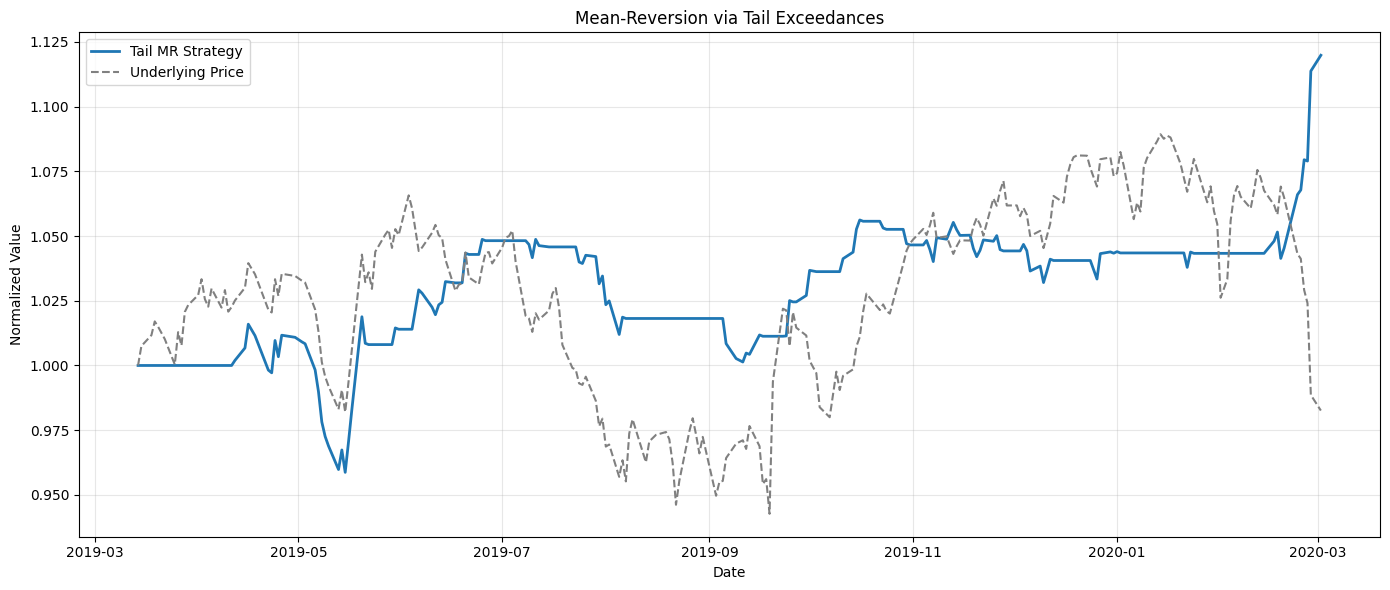

In [16]:
# Run strategy
tail_mr_df = compute_tail_mean_reversion_strategy(
    results, daily_returns[50:], window=20, threshold=1, transaction_cost=0.0005
)

normalized_cum_return = 1 + (tail_mr_df["Cumulative Return"] - tail_mr_df["Cumulative Return"].iloc[0])

plt.figure(figsize=(14, 6))
plt.plot(normalized_cum_return, label="Tail MR Strategy", linewidth=2)
plt.plot(normalized_price, label="Underlying Price", linestyle="--", color="gray")
plt.title("Mean-Reversion via Tail Exceedances")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Three-Layer Tail Mean Reversion Strategy

This strategy implements a mean-reversion logic based on three quantile layers (outer, middle, inner). It enters a **long** position when the return breaches the lower outer quantile and a **short** position when it exceeds the upper outer quantile. Once in a trade, it holds the position as long as returns remain within the middle/inner quantile bands (interpreted as trend continuation). The position is exited if:
- Profit target is hit (return crosses the inner quantile in favor),
- Return reverts inside the inner band (trend reversal),
- Or an opposite tail breach occurs (regime shift).

Transaction costs are accounted for when changing positions.


In [ ]:
def three_layer_tail_mean_reversion_strategy(
    true_returns,
    q_outer_low, q_outer_high,
    q_middle_low, q_middle_high,
    q_inner_low, q_inner_high,
    transaction_cost=0.0005
):
    true_returns = pd.Series(true_returns)
    q_outer_low = pd.Series(q_outer_low)
    q_outer_high = pd.Series(q_outer_high)
    q_middle_low = pd.Series(q_middle_low)
    q_middle_high = pd.Series(q_middle_high)
    q_inner_low = pd.Series(q_inner_low)
    q_inner_high = pd.Series(q_inner_high)

    position = 0
    positions = []
    position = 0
    mode = None

    for i in range(len(true_returns)):

        r = true_returns.iloc[i]
        qo_l = q_outer_low.iloc[i]
        qo_h = q_outer_high.iloc[i]
        qm_l = q_middle_low.iloc[i]
        qm_h = q_middle_high.iloc[i]
        qi_l = q_inner_low.iloc[i]
        qi_h = q_inner_high.iloc[i]

        positions.append(position)

        if mode is None:
            if r < qo_l:
                position = 1
                mode = "long"
            elif r > qo_h:
                position = -1
                mode = "short"

        else:
            if mode == "long" and r > qo_h:
                position = 0
                mode = None
            elif mode == "short" and r < qo_l:
                position = 0
                mode = None
            else:
                if mode == "long":
                    if r > qi_h:
                        position = 0
                        mode = None
                    elif r < qm_l or r < qi_l:
                        continue  # acceptable
                    else:
                        position = 0
                        mode = None

                elif mode == "short":
                    if r < qi_l:
                        position = 0
                        mode = None
                    elif r > qm_h or r > qi_h:
                        position = 0
                        mode = None
                    else:
                        continue  # acceptable
    
    positions = np.array(positions)
    pos_change = np.diff(positions, prepend=0)
    costs = np.abs(pos_change) * transaction_cost
    strategy_returns = positions * true_returns.values - costs
    cumulative_returns = np.cumsum(strategy_returns)

    return pd.DataFrame({
        "Position": positions,
        "Strategy Return": strategy_returns,
        "Cumulative Return": cumulative_returns,
        "Costs": costs
    }, index=true_returns.index)


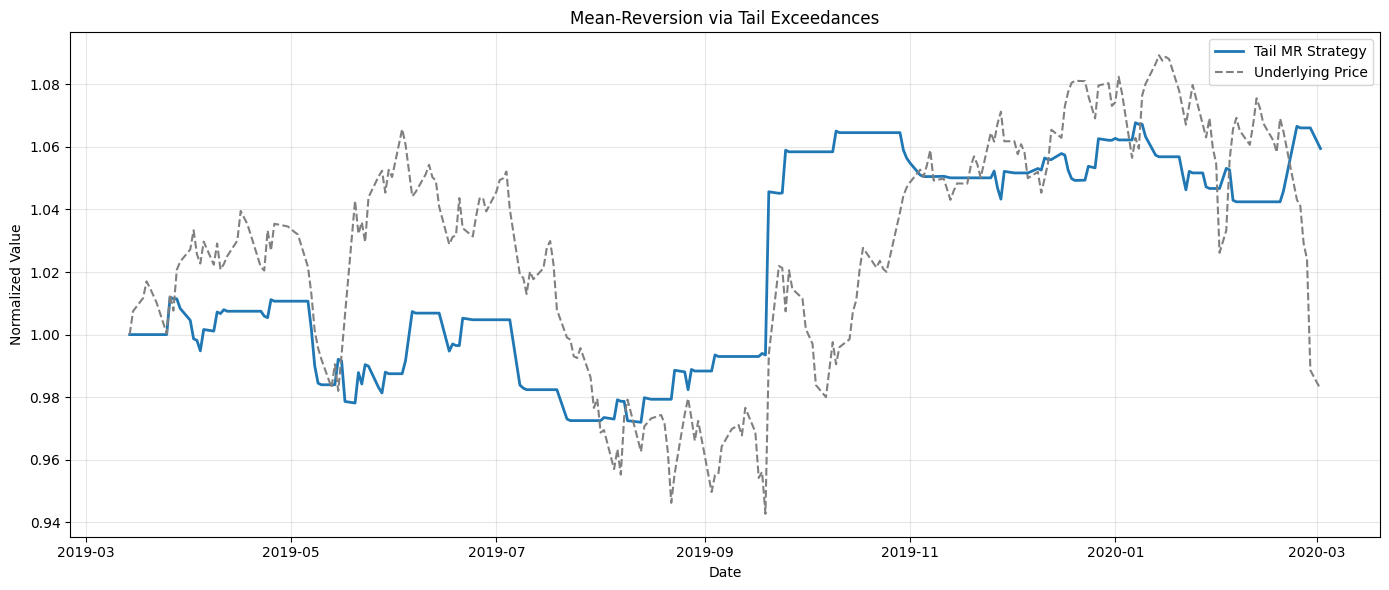

In [18]:
three_layer_df = three_layer_tail_mean_reversion_strategy(
    true_returns=daily_returns[50:],
    q_outer_low=results['return_q0.100'],
    q_outer_high=results['return_q0.900'],
    q_middle_low=results['return_q0.150'],
    q_middle_high=results['return_q0.850'],
    q_inner_low=results['return_q0.250'],
    q_inner_high=results['return_q0.750'],
    transaction_cost=0.0005
)


normalized_cum_return = 1 + (three_layer_df["Cumulative Return"] - three_layer_df["Cumulative Return"].iloc[0])


plt.figure(figsize=(14, 6))
plt.plot(normalized_cum_return, label="Tail MR Strategy", linewidth=2)
plt.plot(normalized_price, label="Underlying Price", linestyle="--", color="gray")
plt.title("Mean-Reversion via Tail Exceedances")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Hourly predictions

Running GARCH-in-Mean forecast...
Data frequency: H
Window size: 50 observations
Minimum periods: 30


c:\Users\catat\Desktop\Econometrics\ecoenv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Generated 1959 forecasts

Coverage Analysis:
90%_band (0.050-0.950):
  Return coverage:  87.24%  | Winkler: 0.0144
  Price coverage:   87.24%   | Winkler: 165.4592
  Valid forecasts:  1959
80%_band (0.100-0.900):
  Return coverage:  80.19%  | Winkler: 0.0111
  Price coverage:   80.19%   | Winkler: 127.1894
  Valid forecasts:  1959
70%_band (0.150-0.850):
  Return coverage:  73.30%  | Winkler: 0.0093
  Price coverage:   73.30%   | Winkler: 106.7133
  Valid forecasts:  1959
50%_band (0.250-0.750):
  Return coverage:  56.00%  | Winkler: 0.0071
  Price coverage:   56.00%   | Winkler: 81.8581
  Valid forecasts:  1959


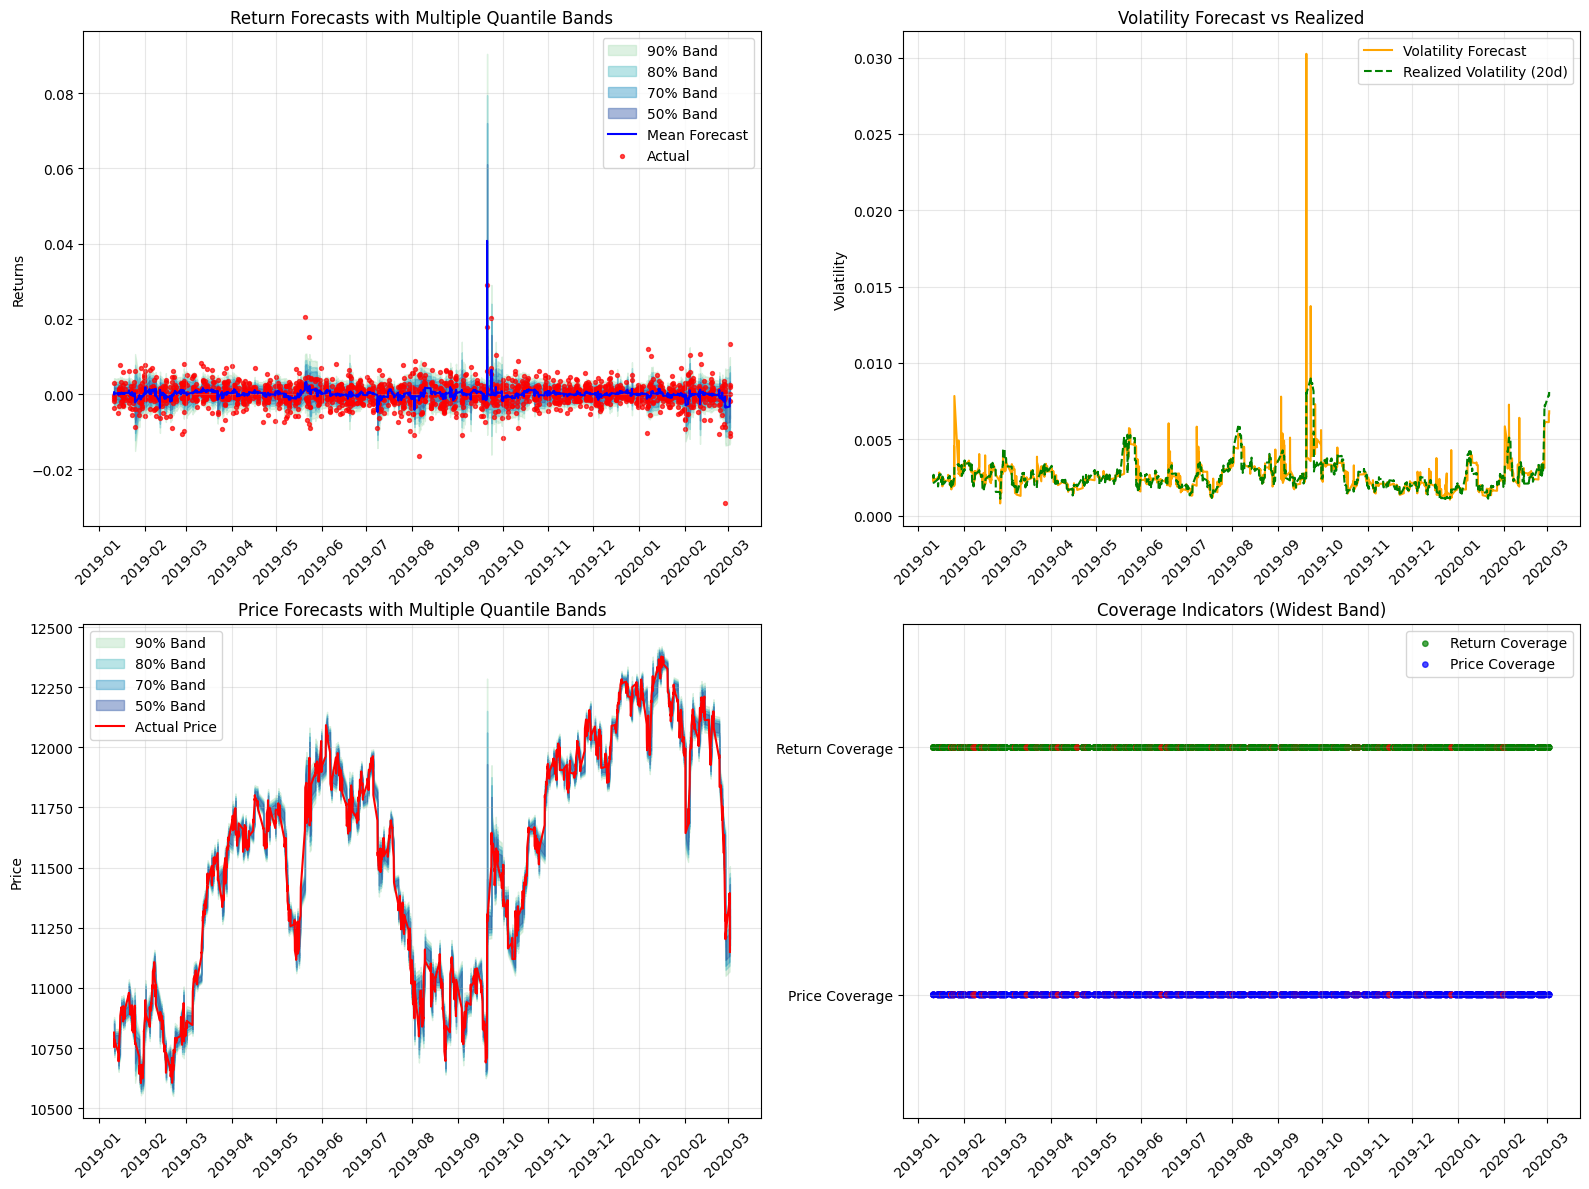

In [19]:
quantiles = [0.05,0.1,0.15,0.25,0.75,0.85,0.9, 0.95]
results_hourly, performance, fig = run_garch_forecast(
    hourly_returns, hourly_prices, 
    window='50H', 
    quantiles=quantiles
)